In [96]:
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import signal


# Data Exploring

Este notebook presenta los datos obtenidos con el osciloscopio sobre cada uno de los tonos de marcado del telefono y muestra el espectro del numero seleccionado.

In [97]:
FILES = "../data/tektronic-2024" 

In [ ]:
# Leemos todos los datos, que están ordenados. TODO Se debe modificar esto para los nombres de los archivos
tones_dict = dict()
for folder in os.listdir(FILES):
    subfolder = os.path.join(FILES,folder)

    if 'TIEMPO' in subfolder:
        
        for file in os.listdir(subfolder):

            if '.CSV' in file:
                data=np.genfromtxt(os.path.join(subfolder,file),delimiter=',')

                name = subfolder.split("Medicion Tono ")[-1].split(" - TIEMPO")[0]
                tones_dict[name] = data[:,4] # Tono

                tiempo  =data[:,3]
# Calculamos el tiempo entre muestras
sample_rate = (tiempo[1]-tiempo[0])
# Y la frecuencia de muestreo
f_muestreo = 1/sample_rate



In [ ]:
# Seleccionamos una tecla a analizar
SHOW_KEY = "0"

# Obtenemos el vector de tension
data = tones_dict[SHOW_KEY]

# Analysis

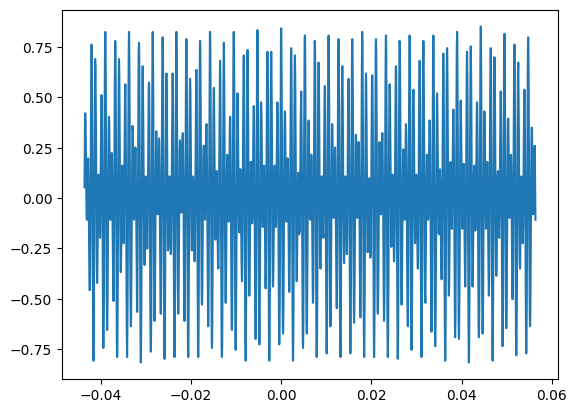

In [111]:
# Señal cruda
plt.figure(dpi=100)
plt.plot(tiempo, data)
plt.show()

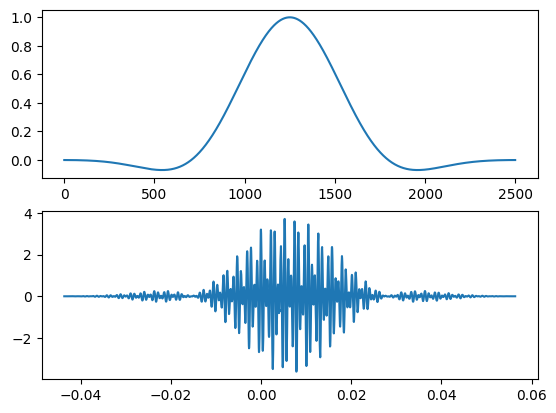

In [112]:
# Creamos ventana
window = signal.windows.get_window("flattop", len(data))
# Calculamos la ganacia de la ventana, para que no nos afecte en la lectura de la amplitud del tono en fourier
window_gain = np.sum(window)/len(window)
# Aplicamos la ventana y normalizamos por la ganancia
data_raw = data
data = (data*window)/window_gain

# Mostramos la ventan utilizada y como queda la señal "ventaneada"
plt.figure(dpi=100)
plt.subplot(2,1,1)
plt.plot(window)
plt.subplot(2,1,2)
plt.plot(tiempo, data)
plt.show()


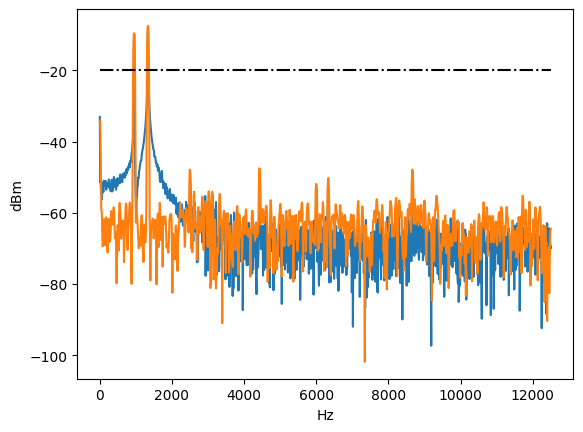

In [113]:
def get_fft_pw(data):
    '''
    Funcion que calcula la transformada rápida de fourier y combierte la amplitud a dBm.
    Retorna el eje de frecuencias y el espectro
    '''
    # Aplicamos la FFT
    f = np.abs(np.fft.fft(data))
    # Normalizamos por el largo
    f /= len(f)
    # Nos quedamos con la parte real, pasamos de tension pico a RMS y normalizamos por haber dividido la potencia de la señal en dos
    f = 2*f[:int(len(f)/2)]/np.sqrt(2)
    # Calculamos el eje de frecuencia
    eje_frec = np.linspace(0, f_muestreo/2, len(f))
    # Pasamos a potencia el espectro
    esp_pot = (f**2)/600  # Sobre una carga de 600 ohms
    esp_pot = 10*np.log10(esp_pot/1e-3)

    return eje_frec, esp_pot

# Calculamos para la señal sin ventana
eje_frec, esp_pot = get_fft_pw(data_raw)
plt.plot(eje_frec, esp_pot)
# Calculamos para la señal con ventana
eje_frec, esp_pot = get_fft_pw(data)
plt.plot(eje_frec, esp_pot)
# Marcamos la potencia minima dada por la norma
plt.hlines([-20], xmin=eje_frec[0], xmax=eje_frec[-1], colors="black", linestyles="-.")
plt.xlabel("Hz")
plt.ylabel("dBm")
plt.show()


In [114]:
# Con esta funcion vamos a buscar los picos en el espectro de potencia
frec_peaks, heights = signal.find_peaks(esp_pot, height=-15)

In [115]:
# Y aqui mostramos lo que obtuvimos
for pos, val in zip(frec_peaks, heights["peak_heights"]):
    print(eje_frec[pos], "Hz : ", val, "dBm")

950.7606084868281 Hz :  -9.625762179378091 dBm
1331.0648518815594 Hz :  -7.549687117997376 dBm
